In [1]:
import polars as pl

import rustystats as rs

import matplotlib.pyplot as plt
import numpy as np

data = pl.read_parquet("https://raw.githubusercontent.com/PricingFrontier/pricing-data-example/917c853e256df8d5814721ab56f72889a908bb08/data/processed/frequency_set.parquet")

In [2]:
exploration = rs.explore_data(
    data=data,
    response="ClaimCount",
    categorical_factors=["Region", "Area"],
    continuous_factors=["VehPower", "VehAge"],
    exposure="Exposure",
)

In [3]:
exploration.to_json()

'{"data_summary": {"n_rows": 678012, "n_columns": 13, "response_column": "ClaimCount", "exposure_column": "Exposure", "n_categorical_factors": 2, "n_continuous_factors": 2}, "factor_stats": [{"name": "VehPower", "type": "continuous", "mean": 6.454630596508617, "std": 2.050905590758379, "min": 4.0, "max": 15.0, "missing_count": 0, "missing_pct": 0.0, "response_by_bin": [{"bin_index": 1, "bin_lower": 4.0, "bin_upper": 5.0, "count": 115349, "exposure": 60073.637303557, "response_sum": 5605.0, "response_rate": 0.09330215801113352}, {"bin_index": 3, "bin_lower": 5.0, "bin_upper": 6.0, "count": 124821, "exposure": 68173.348820864, "response_sum": 7159.0, "response_rate": 0.10501171093723703}, {"bin_index": 5, "bin_lower": 6.0, "bin_upper": 7.0, "count": 148976, "exposure": 82524.210171993, "response_sum": 8260.0, "response_rate": 0.10009183950727797}, {"bin_index": 7, "bin_lower": 7.0, "bin_upper": 8.0, "count": 145400, "exposure": 77949.53670018699, "response_sum": 7503.0, "response_rate": 

In [16]:
data = data.with_columns([
    pl.col("Density").log().alias("log_Density"),
    pl.col("BonusMalus").log().alias("log_BonusMalus"),
])

formula = """
    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)
"""

model = rs.glm(
    formula=formula,
    data=data,
    family="poisson",
    offset="Exposure"
).fit(alpha=0.5, l1_ratio=0.5)

In [17]:
print(model.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677994
Method:              IRLS + Elasticnet Df Model:                    17
Scale:               1.0000          Alpha (λ):               0.5000
L1 Ratio:            0.50            Iterations:                  25
Non-zero coefs:      17             

Log-Likelihood:         -140777.2119 Deviance:                212554.2776
AIC:                     281590.4237 Null Deviance:           214041.4441
BIC:                     281796.1083 Pearson chi2:         10117940026.49
Converged:           False          

------------------------------------------------------------------------------
Variable                  Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept              -3.121

In [6]:
# Predict on the data
predictions = model.predict(data, offset="Exposure")
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim rate: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

Predictions shape: (678012,)
Mean predicted claim rate: 0.052473
Min: 0.000000, Max: 1.454319


In [7]:
def plot_ae_chart(
    data: pl.DataFrame,
    factor: str,
    bins: list = None,
    use_rate: bool = False,
    figsize: tuple = (12, 4),
    title: str = None,
):
    """
    Plot Actual vs Expected chart with exposure bars and A/E ratio.
    
    Parameters
    ----------
    data : pl.DataFrame
        Data with 'Actual', 'Predicted', and 'Exposure' columns.
    factor : str
        Column name to group by.
    bins : list, optional
        For continuous factors, bin edges. If None, treats factor as categorical.
    use_rate : bool
        If True, plot rates (per exposure) instead of counts.
    figsize : tuple
        Figure size.
    title : str, optional
        Custom title. Defaults to factor name.
    """
    # Bin continuous factors if bins provided
    if bins is not None:
        bin_col = f"{factor}_bin"
        grouped = data.with_columns([
            pl.col(factor).cut(bins).alias(bin_col)
        ]).group_by(bin_col).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ])
        
        # Create proper sort order based on bin edges (not alphabetical)
        bin_labels = grouped[bin_col].to_list()
        # Extract the lower bound from each bin label for sorting
        def get_bin_lower(label):
            if label is None:
                return float('inf')
            s = str(label)
            # Handle formats like "(0, 2]" or "(-inf, 0]"
            try:
                lower = s.split(',')[0].strip('([')
                if lower == '-inf':
                    return float('-inf')
                return float(lower)
            except:
                return float('inf')
        
        sort_order = sorted(range(len(bin_labels)), key=lambda i: get_bin_lower(bin_labels[i]))
        grouped = grouped[sort_order]
        labels = [str(b) for b in grouped[bin_col].to_list()]
    else:
        grouped = data.group_by(factor).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ]).sort(factor)
        labels = [str(v) for v in grouped[factor].to_list()]
    
    # Calculate A/E and rates
    grouped = grouped.with_columns([
        (pl.col("Actual") / pl.col("Expected")).alias("A/E"),
        (pl.col("Actual") / pl.col("Exposure")).alias("Actual_Rate"),
        (pl.col("Expected") / pl.col("Exposure")).alias("Expected_Rate")
    ])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    x = np.arange(len(labels))
    
    # Left: Exposure bar with Actual/Expected lines
    ax1 = axes[0]
    ax2 = ax1.twinx()
    
    ax1.bar(x, grouped["Exposure"].to_numpy(), alpha=0.3, color="gray", label="Exposure")
    ax1.set_ylabel("Exposure", color="gray")
    ax1.tick_params(axis="y", labelcolor="gray")
    ax1.set_ylim(bottom=0)
    
    if use_rate:
        y_actual = grouped["Actual_Rate"].to_numpy()
        y_expected = grouped["Expected_Rate"].to_numpy()
        y_label = "Claim Rate"
    else:
        y_actual = grouped["Actual"].to_numpy()
        y_expected = grouped["Expected"].to_numpy()
        y_label = "Claim Count"
    
    ax2.plot(x, y_actual, "o-", color="steelblue", linewidth=2, markersize=8, label="Actual")
    ax2.plot(x, y_expected, "s--", color="coral", linewidth=2, markersize=8, label="Expected")
    ax2.set_ylabel(y_label, color="black")
    ax2.set_ylim(bottom=0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    ax1.set_xlabel(title or factor)
    ax1.set_title(f"Actual vs Expected by {title or factor}")
    ax2.legend(loc="upper left")
    
    # Right: A/E ratio
    ae_vals = grouped["A/E"].to_numpy()
    colors = ["green" if 0.95 <= v <= 1.05 else "orange" if 0.9 <= v <= 1.1 else "teal" for v in ae_vals]
    axes[1].bar(labels, ae_vals, color=colors)
    axes[1].axhline(y=1.0, color="red", linestyle="--", label="Perfect calibration")
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    axes[1].set_xlabel(title or factor)
    axes[1].set_ylabel("A/E Ratio")
    axes[1].set_title(f"A/E Ratio by {title or factor}")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return grouped

In [8]:
print(formula)


    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)



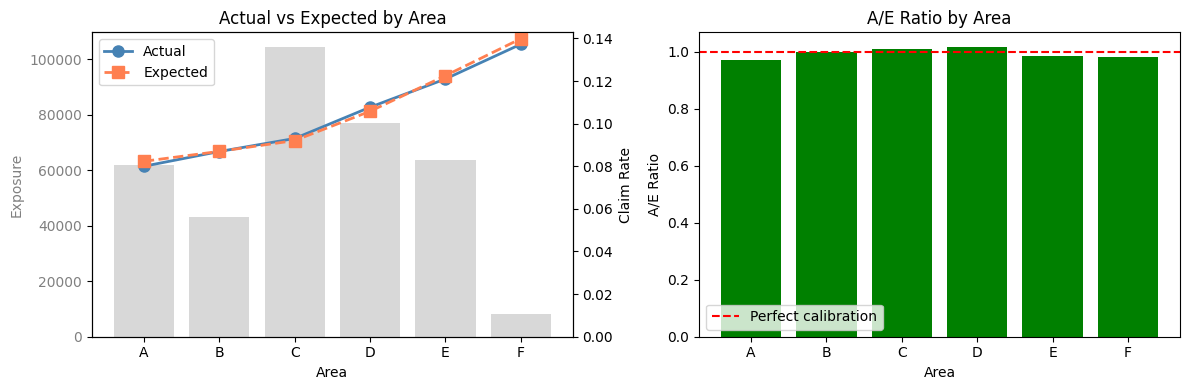

Area,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""A""",4958,5101.980875,61969.377712,0.971779,0.080007,0.082331
"""B""",3739,3741.702474,43012.323931,0.999278,0.086929,0.086991
"""C""",9719,9616.990357,104449.003784,1.010607,0.09305,0.092074
"""D""",8307,8160.167671,77119.271692,1.017994,0.107716,0.105812
"""E""",7721,7819.661129,63819.31427,0.987383,0.120982,0.122528
"""F""",1116,1137.068798,8129.234074,0.981471,0.137282,0.139874


In [9]:
plot_ae_chart(plot_data, "Area", use_rate=True)

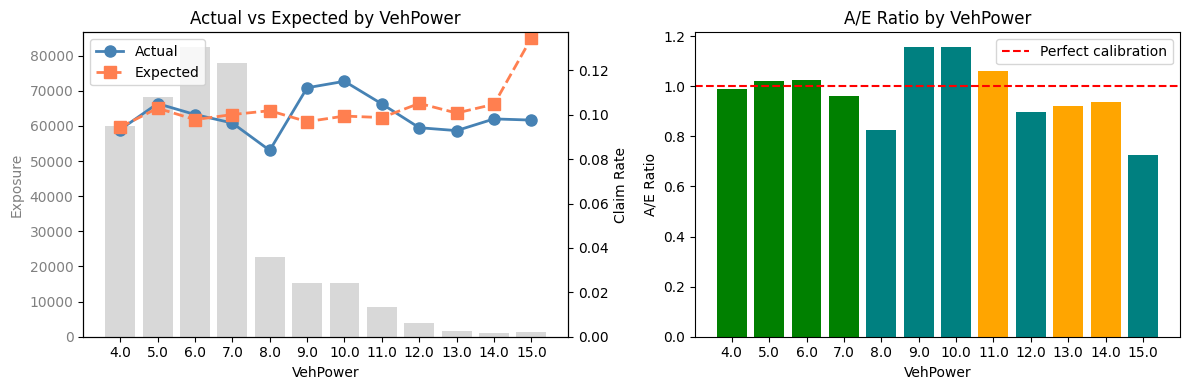

VehPower,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
f64,i32,f64,f64,f64,f64,f64
4.0,5605,5668.841632,60073.637304,0.988738,0.093302,0.094365
5.0,7159,7018.355452,68173.348821,1.02004,0.105012,0.102949
6.0,8260,8069.739853,82524.210172,1.023577,0.100092,0.097786
7.0,7503,7800.57778,77949.5367,0.961852,0.096255,0.100072
8.0,1904,2309.214126,22684.616305,0.824523,0.083934,0.101796
…,…,…,…,…,…,…
11.0,891,838.866352,8497.778452,1.062148,0.104851,0.098716
12.0,357,398.489033,3792.038343,0.895884,0.094145,0.105086
13.0,152,164.968513,1637.255322,0.921388,0.092838,0.100759


In [10]:
plot_ae_chart(plot_data, "VehPower", use_rate=True)

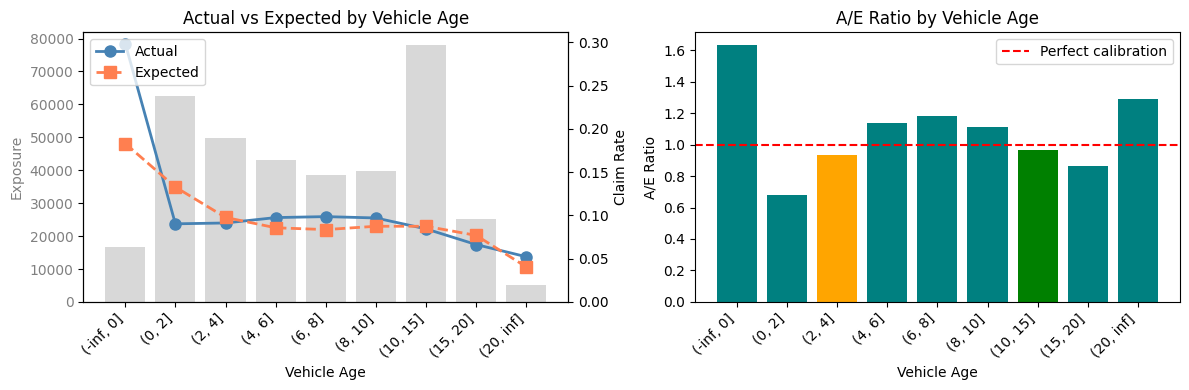

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3062.244185,16719.028729,1.631483,0.298821,0.183159
"""(0, 2]""",5641,8296.194118,62457.026619,0.67995,0.090318,0.13283
"""(2, 4]""",4550,4871.071246,49841.358576,0.934086,0.09129,0.097732
"""(4, 6]""",4193,3686.234354,42987.678107,1.137475,0.09754,0.085751
"""(6, 8]""",3797,3219.349994,38486.488979,1.179431,0.098658,0.083649
"""(8, 10]""",3858,3476.436142,39732.594475,1.109757,0.097099,0.087496
"""(10, 15]""",6588,6823.397537,77990.975407,0.965501,0.084471,0.08749
"""(15, 20]""",1668,1934.236506,25136.158607,0.862356,0.066359,0.07695
"""(20, inf]""",269,208.407223,5147.215965,1.290742,0.052261,0.040489


In [11]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

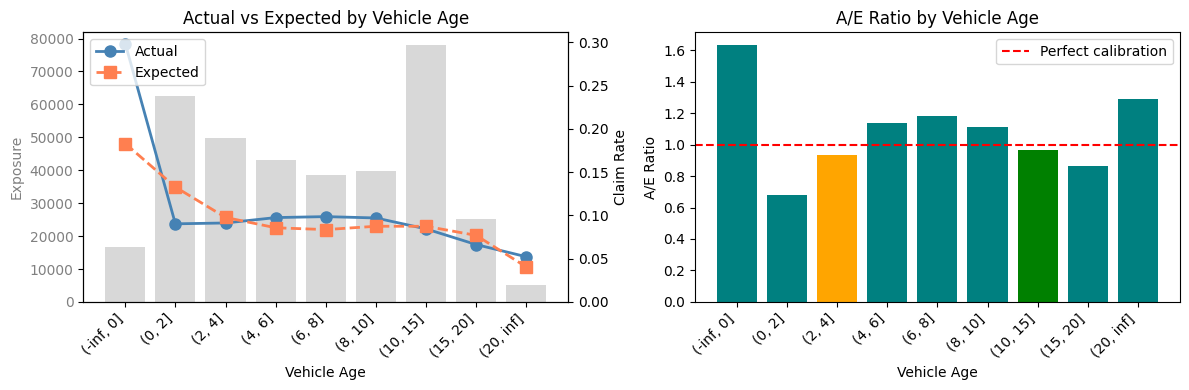

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3062.244185,16719.028729,1.631483,0.298821,0.183159
"""(0, 2]""",5641,8296.194118,62457.026619,0.67995,0.090318,0.13283
"""(2, 4]""",4550,4871.071246,49841.358576,0.934086,0.09129,0.097732
"""(4, 6]""",4193,3686.234354,42987.678107,1.137475,0.09754,0.085751
"""(6, 8]""",3797,3219.349994,38486.488979,1.179431,0.098658,0.083649
"""(8, 10]""",3858,3476.436142,39732.594475,1.109757,0.097099,0.087496
"""(10, 15]""",6588,6823.397537,77990.975407,0.965501,0.084471,0.08749
"""(15, 20]""",1668,1934.236506,25136.158607,0.862356,0.066359,0.07695
"""(20, inf]""",269,208.407223,5147.215965,1.290742,0.052261,0.040489


In [12]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

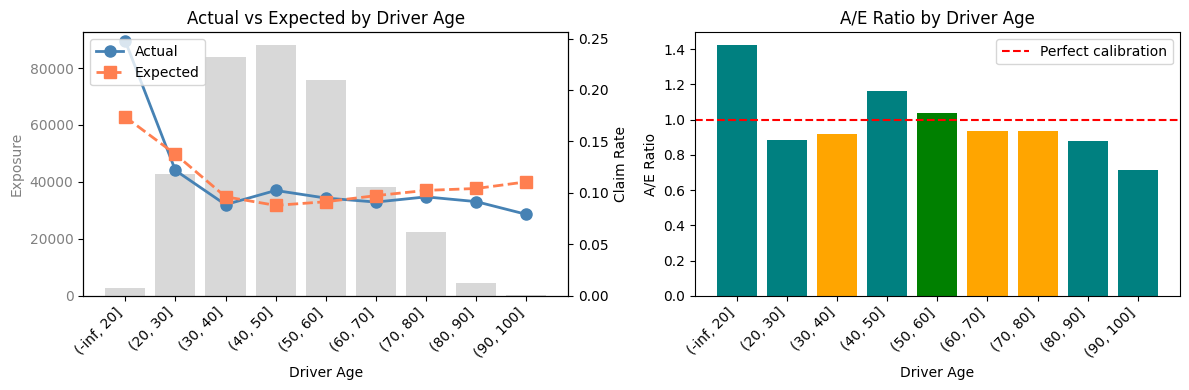

DrivAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 20]""",640,449.169956,2584.582839,1.42485,0.247622,0.173788
"""(20, 30]""",5218,5889.847016,42822.634243,0.885931,0.121851,0.137541
"""(30, 40]""",7435,8073.358692,83937.299011,0.92093,0.088578,0.096183
"""(40, 50]""",9021,7743.289929,88138.310203,1.165009,0.10235,0.087854
"""(50, 60]""",7190,6920.211557,75727.63601,1.038986,0.094946,0.091383
"""(60, 70]""",3491,3730.496553,38332.688531,0.9358,0.091071,0.097319
"""(70, 80]""",2138,2278.201271,22246.083144,0.93846,0.096107,0.102409
"""(80, 90]""",402,458.018967,4393.353277,0.877693,0.091502,0.104253
"""(90, 100]""",25,34.977364,315.938204,0.714748,0.079129,0.11071


In [13]:
plot_ae_chart(plot_data, "DrivAge", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Driver Age")

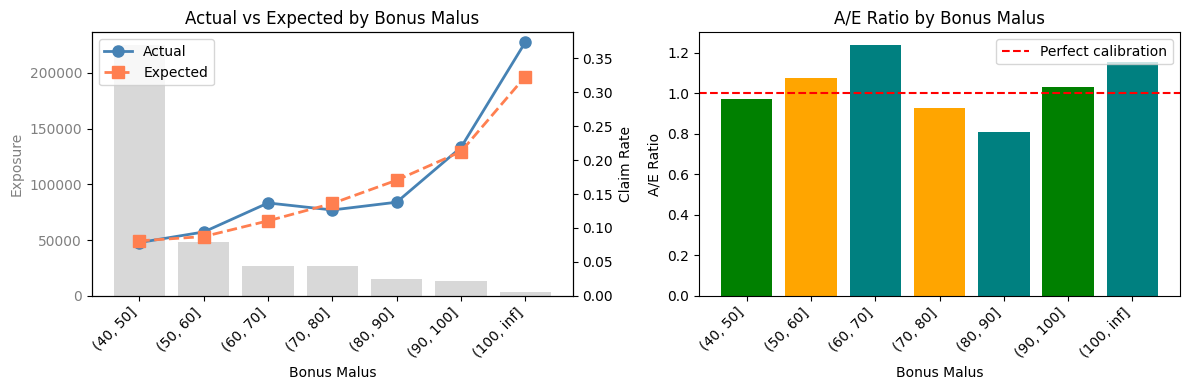

BonusMalus_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(40, 50]""",17688,18243.007043,225233.130902,0.969577,0.078532,0.080996
"""(50, 60]""",4515,4189.464272,47985.497013,1.077703,0.094091,0.087307
"""(60, 70]""",3627,2927.715772,26497.713499,1.23885,0.13688,0.110489
"""(70, 80]""",3361,3617.010393,26567.633294,0.92922,0.126507,0.136143
"""(80, 90]""",2104,2598.628061,15246.839478,0.809658,0.137996,0.170437
"""(90, 100]""",2930,2847.259143,13396.392272,1.02906,0.218716,0.212539
"""(100, inf]""",1335,1154.486618,3571.319003,1.156358,0.373811,0.323266


In [14]:
plot_ae_chart(plot_data, "BonusMalus", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Bonus Malus")

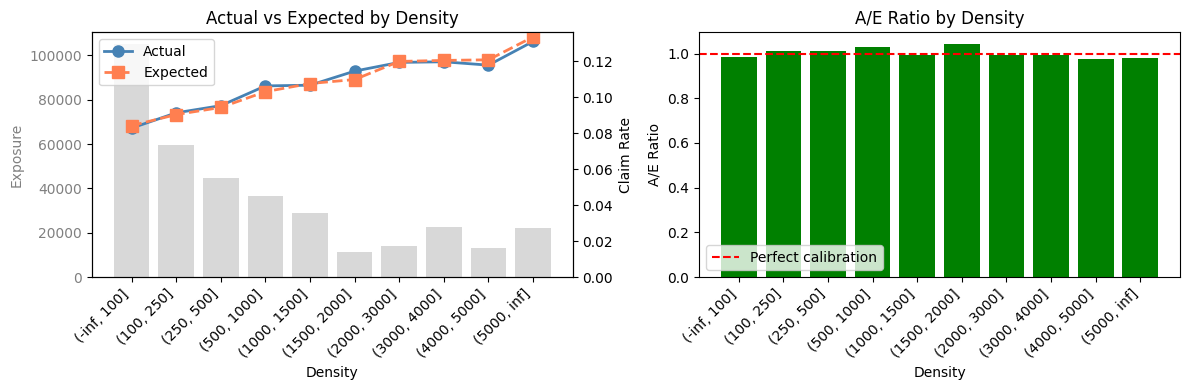

Density_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 100]""",8707,8851.542098,105067.386255,0.98367,0.082871,0.084246
"""(100, 250]""",5460,5401.694483,59766.263508,1.010794,0.091356,0.09038
"""(250, 500]""",4257,4212.157694,44644.931144,1.010646,0.095352,0.094348
"""(500, 1000]""",3912,3794.120057,36793.095132,1.031069,0.106324,0.10312
"""(1000, 1500]""",3088,3115.335582,28937.801585,0.991225,0.106712,0.107656
"""(1500, 2000]""",1299,1245.991462,11340.499495,1.042543,0.114545,0.109871
"""(2000, 3000]""",1678,1685.615322,14054.663173,0.995482,0.119391,0.119933
"""(3000, 4000]""",2706,2723.167324,22601.158855,0.993696,0.119728,0.120488
"""(4000, 5000]""",1535,1573.703774,13024.424481,0.975406,0.117855,0.120827


In [15]:
plot_ae_chart(plot_data, "Density", bins=[100, 250, 500, 1000, 1500, 2000,3000,4000,5000], use_rate=True, title="Density")